# A Physiological-Twin for Alcohol Consumption -- Connecting short-term drinking habits to plasma PEth

This project describe the appearance of alcohol in blood [mg/dL], breakdown to acetaldehyde, and conversion to phosphatidylethanol (PEth). 

We implemented the model in two different frameworks to make it more accessible. The primary work was done in MATLAB using [IQM tools by IntiQuan](https://iqmtools.intiquan.com/), but we also provide a Python implementation in a custom toolbox.

The Python implementation was implemented using a custom toolbox inspired by the IQM tools. The SUND (SimUlation of Nonlinear Dynamic models) toolbox is still in development, but an initial version is available [here](https://isbgroup.eu/edu/assets/sund-1.0.3.1.tar.gz). To install all packages needed, the simplest way is to install the packages defined in the `python/requirements.txt` file using `pip install -r requirements.txt`. Typically, you want to create a new virtual environment before installing the packages, e.g. using `pipenv shell`. We ran the Python scripts using Python 3.12. 

The SUND toolbox is built around a modular object-oriented approach, where models have outputs and inputs, which can come from other models or what we call "activities". In this project, the activities correspond to the drinks and meals. 

Please note that we did not include simulations of the rejected alternative hypothesis in the python example, only the accepted model. 

If you use this model, please cite as: 

> A Physiologically Based Digital Twin for Alcohol Consumption – Predicting Real-life Drinking Responses and Long-term Plasma PEth.
Henrik Podéus, Christian Simonsson, Patrik Nasr, Mattias Ekstedt, Stergios Kechagias, Peter Lundberg, William Lövfors, Gunnar Cedersund.
bioRxiv 2023.08.18.553836; doi: https://doi.org/10.1101/2023.08.18.553836 

---

First, we need to import the necessary python packages. 

In [1]:
# %% Import packages
import matplotlib.pyplot as plt
import sund
import numpy as np
import json
import copy

Next, we setup the model object, and load the optimal parameter values.

In [2]:
# %% Setup model and model object, and load parameter values
model_name =  'alcohol_model'

sund.installModel(f"./Models/{model_name}.txt")
Alcohol_model = sund.importModel(model_name)
model = Alcohol_model() 

with open("./Models/alcohol_model (187.19).json",'r') as f:
    param_in = json.load(f)
    params = param_in['x']

Model 'alcohol_model' is already installed and up to date.


Next, we load the experimental data, and split it into estimation and validation datasets. Note that the simulation of Javors low dose is needed to calculate the Javors combined data, and therefore we include the simulation of Javors low in the estimation dataset but set the SEM to infinity. By setting the SEM to infinity, we remove that dataset from the cost calculations. 

In [3]:
# %% Load and setup experimental data
with open('../data.json','r') as f:
    all_data = json.load(f)

for d in all_data.values():
    d.pop("meta",None)

validation_experiments = ["Okabe_Water2", "Okabe_Glucose", "Okabe_UG400", "Sarkola", "Javors_Low", "Frezza_Woman", "Frezza_Men"]

estimation_data = {k:d.copy() for k,d in all_data.items() if k not in validation_experiments}
estimation_data["Sarkola"] = copy.deepcopy(all_data["Sarkola"])
estimation_data["Sarkola"].pop("EtOH") #split the Sarkola data into estimation/validation group

estimation_data["Javors_Low"]= copy.deepcopy(all_data["Javors_Low"])
estimation_data["Javors_Low"]["PEth"]["SEM"] = np.inf # Disables using PEth data from Javors_Low in the cost calculations
estimation_data["Javors_Low"]["BrAC"]["SEM"] = np.inf # Disables using BrAC data from Javors_Low in the cost calculations

validation_data = {k:d.copy() for k,d in all_data.items() if k in validation_experiments}
validation_data["Sarkola"].pop("Acetate") #split the Sarkola data into estimation/validation group

print(estimation_data.keys())
print(validation_data.keys())

dict_keys(['Mitchell_Beer', 'Mitchell_Wine', 'Mitchell_Spirit', 'Jones_Food', 'Jones_Fasting', 'Okabe_Water', 'Okabe_Orange', 'Okabe_Orange_Syrup', 'Okabe_Milk', 'Okabe_Milk_Water', 'Okabe_Whiskey', 'Okabe_UG200', 'Okabe_UG600', 'Kechagias_Fasting', 'Kechagias_Breakfast', 'Javors_High', 'Javors_Combined', 'Sarkola', 'Javors_Low'])
dict_keys(['Sarkola', 'Okabe_Water2', 'Okabe_Glucose', 'Okabe_UG400', 'Javors_Low', 'Frezza_Woman', 'Frezza_Men'])


Next, we define functions to help us create the simulation objects. Then we create the simulation objects. 

In [4]:
# %% Define simulation object creation helpers
def create_sim(model, t, vol, conc, t_drinks, kcal, kcal_food, sex, weight, height):
    pwc = sund.PIECEWISE_CONSTANT # space saving only
    const = sund.CONSTANT # space saving only

    act = sund.Activity(timeunit = 'm')
    act.AddOutput(name = "EtOH_conc", type=pwc, tvalues = t, fvalues = [0] + conc, feature = True) 
    vol_drink_per_t = [v/t if t>0 else 0 for v,t in zip(vol, t_drinks)]
    act.AddOutput(name = "vol_drink_per_time", type=pwc, tvalues = t, fvalues = [0] + vol_drink_per_t, feature = True) 
    act.AddOutput(name = "kcal_liquid_per_vol", type=const, fvalues = kcal, feature = True)
    act.AddOutput(name = "kcal_solid", type=const, fvalues = kcal_food, feature = True)
    act.AddOutput(name = "drink_length", type=pwc, tvalues = t, fvalues = [0] + t_drinks, feature = True)
    act.AddOutput(name = "sex", type=const, fvalues = sex, feature = True)
    act.AddOutput(name = "weight", type=const, fvalues = weight, feature = True)
    act.AddOutput(name = "height", type=const, fvalues = height, feature = True)

    sim = sund.Simulation(models = model, activities = act, timeunit = 'm')
    return sim


def create_sim_from_data(model, inputs, use_as_feature=True): 
    pwc = sund.PIECEWISE_CONSTANT # space saving only
    const = sund.CONSTANT # space saving only

    act = sund.Activity(timeunit = 'm')
    for key, inp in inputs.items():
        if len(inp["t"])>1:
            act.AddOutput(name = key, type=pwc, tvalues = np.array(inp["t"][1:]), fvalues = np.array(inp["f"]), feature = use_as_feature) 
        else:
            act.AddOutput(name = key, type=const, fvalues = np.array(inp["f"]), feature = True)

    sim = sund.Simulation(models = model, activities = act, timeunit = 'm')
    return sim

# %% Setup simulation object
sims = dict()

for k, v in all_data.items():
    if k == "Javors_Combined":
        continue
    else:
        sims[k] = create_sim_from_data(model, v["input"])

One PEth dataset from the Javors paper was a combined dataset from two other dataset (low/high dose). Since the dataset was created by taking the weighted average of the two datasets, we do the same calculation with the simulation. 

The low dose consisted of 16 measurements, and the high dose of 11 measurements. 

In [5]:
# %% Define a function to get the combined PEth
def combine_PEth(low, high):
    return  (np.array(low) * 16 + np.array(high) * 11) / (16 + 11)


Next, we define the objective function to evaluate the agreement between the simulation and data (cost), referred to here as the *cost function*. Then, we calculate the cost.

Note that due to numerical differences, the simulation and cost is *slightly* different from the MATLAB implementation. Further, note that the MATLAB implementation was used to train and test the model and thus the values here slightly differ from the values in the manuscript. 

The threshold of rejection is 226.4. Model simulations with costs greater than this should be rejected. When we simulate the model, the cost is 187.19, which is below the threshold for rejection and thus acceptable. 

In [6]:
# %% Define cost function, calculcate cost for the loaded parameter sets
def f_cost(p, sims, D, print_costs = False):
    ic_PEth_L = p[-2]
    ic_PEth_H = p[-1]
    p = p[0:-2]
    p_names = model.parameternames
    ic = model.statevalues
    PEth_bound_scale = p[p_names.index("kPEth_bind")] / p[p_names.index("kPEth_release")] + 1

    cost = 0
    for k_exp, d in D.items():
        # Javors special cases
        if k_exp == "Javors_Combined":
            continue
        elif k_exp == "Javors_Low":
            ic[model.statenames.index("PEth")] = ic_PEth_L
            ic[model.statenames.index("PEth_Bound")] = ic_PEth_L*PEth_bound_scale
        elif  k_exp == "Javors_High":
            ic[model.statenames.index("PEth")] = ic_PEth_H
            ic[model.statenames.index("PEth_Bound")] = ic_PEth_H*PEth_bound_scale

        times = [t for k, var in d.items()  if k not in ["input", "meta", "extra"] for t in var["Time"]]+[0]

        if "Javors" in k_exp:
            times+=D["Javors_Combined"]["PEth"]["Time"]

        times = np.unique(np.array(times))
        
        sim = sims[k_exp]
        sim.ResetStatesDerivatives()        
        sim.Simulate(timevector = times, parametervalues = p,  statevalues = ic)

        for k_obs, obs in d.items():
            if k_obs not in ["input", "meta", "extra"]:
                idx = sim.featurenames.index(k_obs)
                y_sim = sim.featuredata[:,idx]

                if any([e in k_exp for e in ["Javors", "Okabe"]]): # If the experiment is either a Javors or an Okabe experiment, remove the basal value
                    if "Low" in k_exp:
                        PEth_L = y_sim.copy() 
                        PEth_t = sim.timevector
                    elif "High" in k_exp:
                        PEth_H = y_sim.copy()
                    y_sim-=y_sim[0]

                y_sim = [y for y,t in zip(y_sim, sim.timevector) if t in obs["Time"]] # only keep sim_times that is also in data. Useful if observables have different number of observables 
                y = np.array(obs['Mean'])
                sem = np.array(obs['SEM'])
                c = np.square((y-y_sim)/sem).sum() # Cost for the current experiment/variable
                cost += c

                if print_costs and not (k_exp == "Javors_Low" and c == 0):
                    print(f"{k_exp}-{k_obs}: {c}")

    if "Javors_Combined" in D.keys():
        obs = D["Javors_Combined"]["PEth"]
        y_sim = combine_PEth(PEth_L, PEth_H)
        y_sim = [y for y,t in zip(y_sim, PEth_t) if t in obs["Time"]] # only keep sim_times that is also in data. Useful if observables have different number of observables 
        y = np.array(obs['Mean'])
        sem = np.array(obs['SEM'])

        c = np.square((y-y_sim)/sem).sum() # Cost for the current experiment/variable
        cost += c
        if print_costs:
            print(f"Javors_Combined-PEth: {c}")

    return cost

print(f"Cost for p_start: {f_cost(params, sims, estimation_data, print_costs=True)}")

Mitchell_Beer-EtOH: 9.813464646268507
Mitchell_Wine-EtOH: 2.4789540089226287
Mitchell_Spirit-EtOH: 3.825534774475816
Jones_Food-EtOH: 3.406922198550563
Jones_Fasting-EtOH: 23.134420097780218
Okabe_Water-Gastric volume: 3.2698010752475497
Okabe_Orange-Gastric volume: 0.9409867887602976
Okabe_Orange_Syrup-Gastric volume: 8.240257749559607
Okabe_Milk-Gastric volume: 11.775395213647968
Okabe_Milk_Water-Gastric volume: 1.357253678985225
Okabe_Whiskey-Gastric volume: 2.404216116948224
Okabe_UG200-Gastric volume: 10.865277691212068
Okabe_UG600-Gastric volume: 3.9558792909958025
Kechagias_Fasting-EtOH: 34.91211186733068
Kechagias_Breakfast-EtOH: 10.794417764897853
Javors_High-BrAC: 49.24609948714289
Javors_High-PEth: 3.10576954791724
Sarkola-Acetate: 1.6688894292964136
Javors_Combined-PEth: 1.9958077796286149
Cost for p_start: 187.19145920756816


Next, we simulate and plot the agreement to data. 

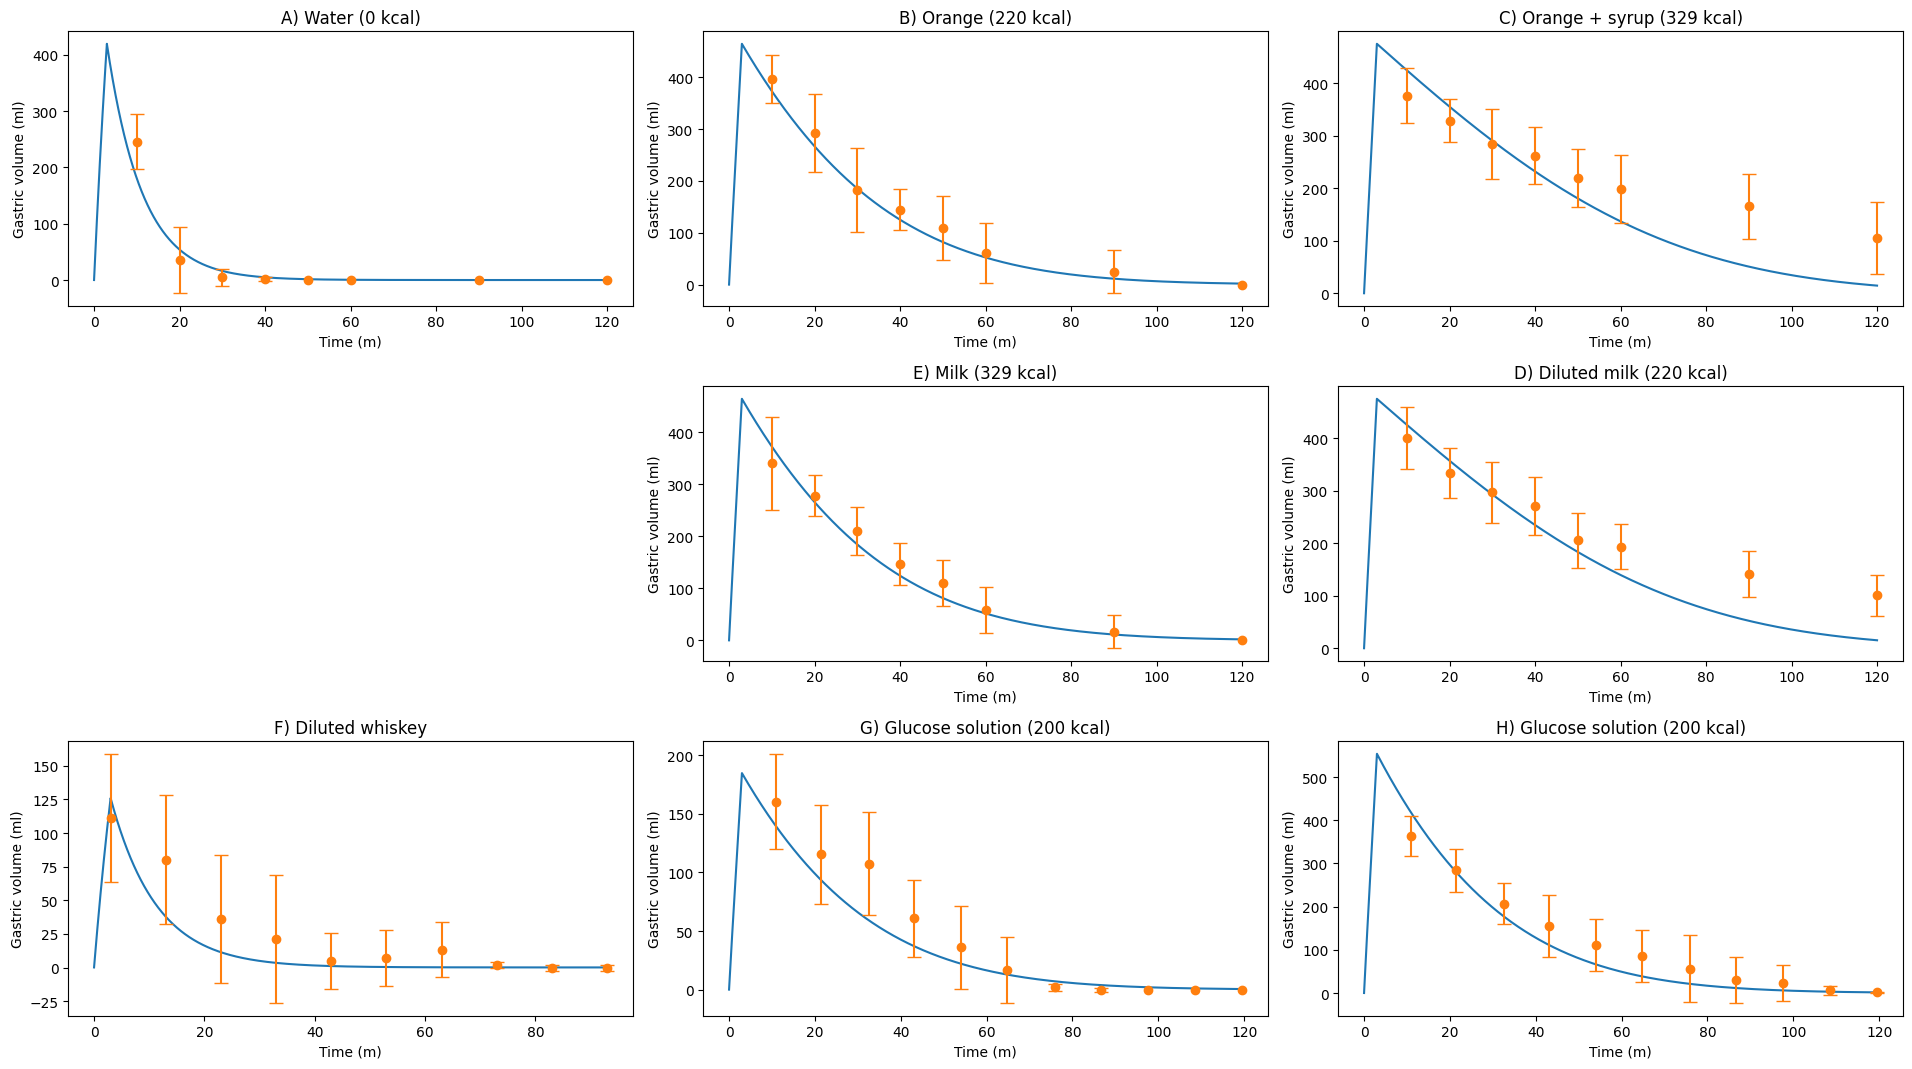

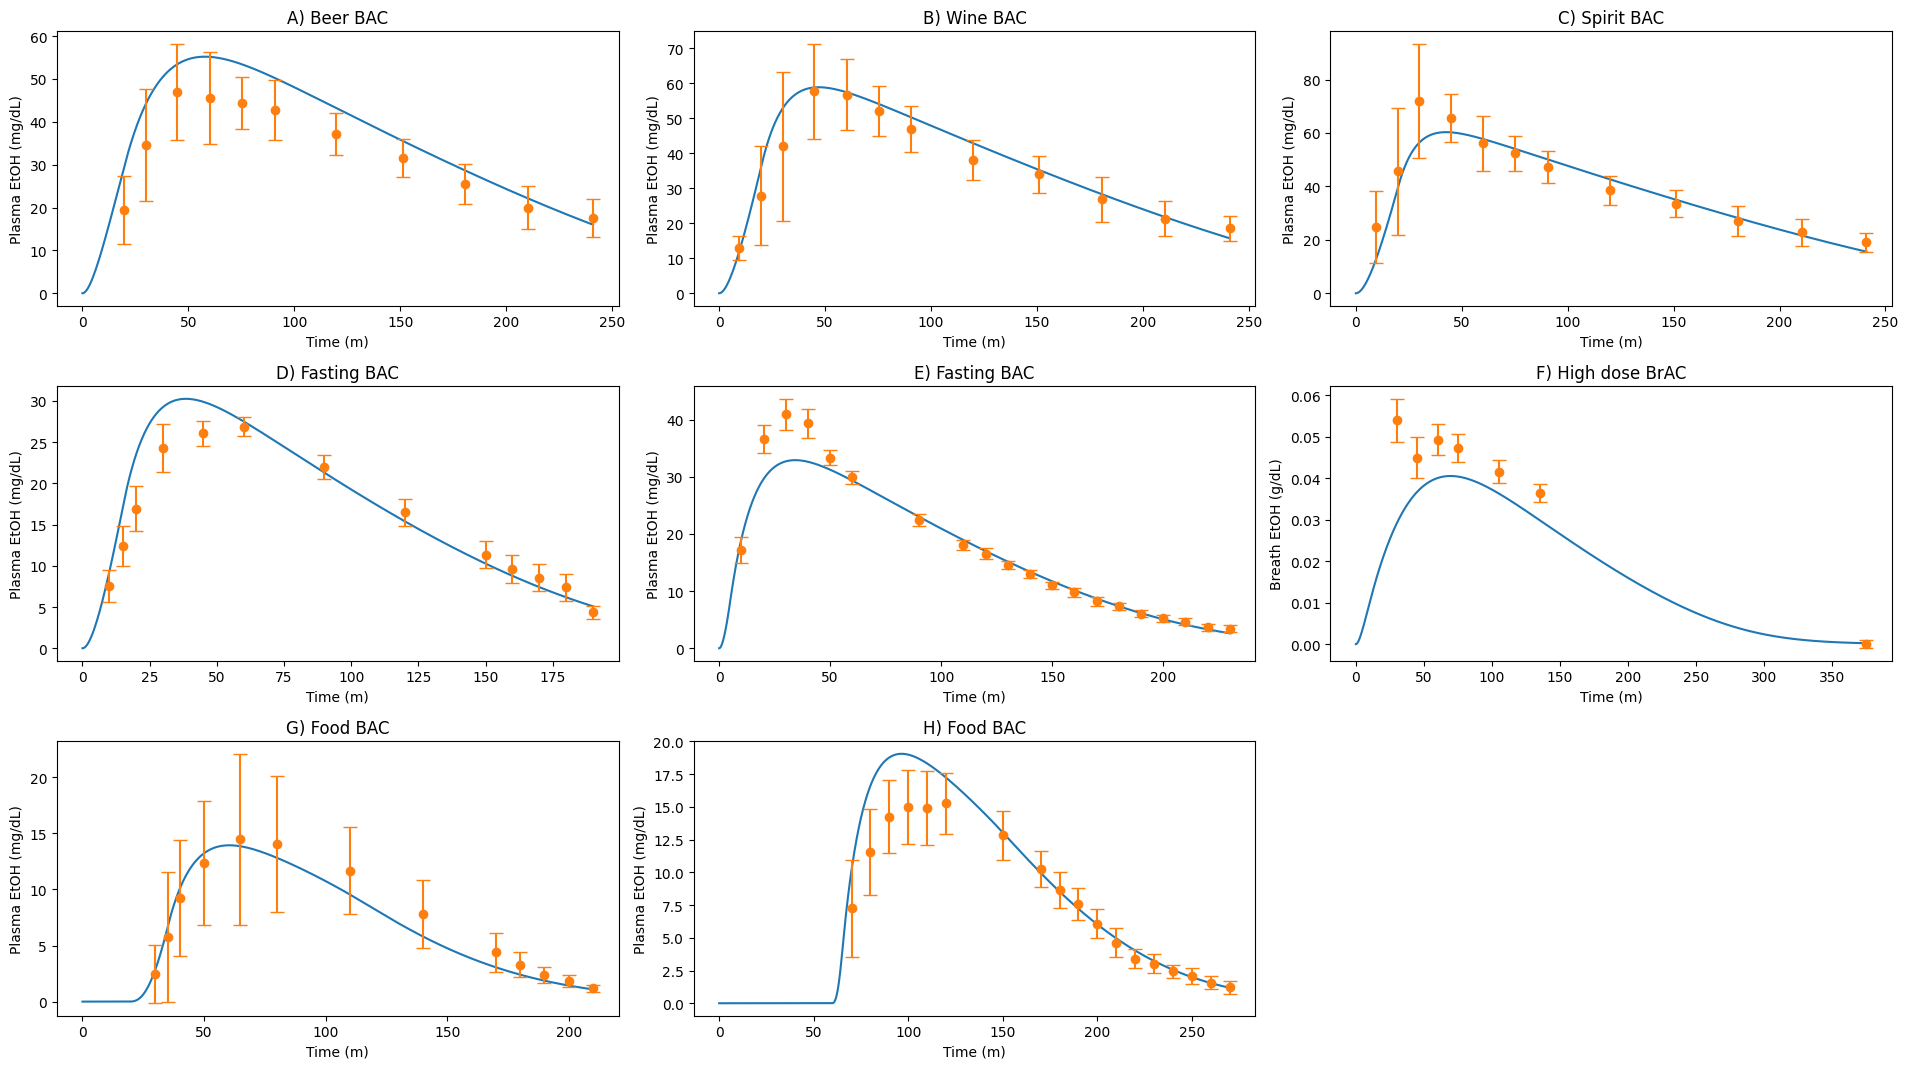

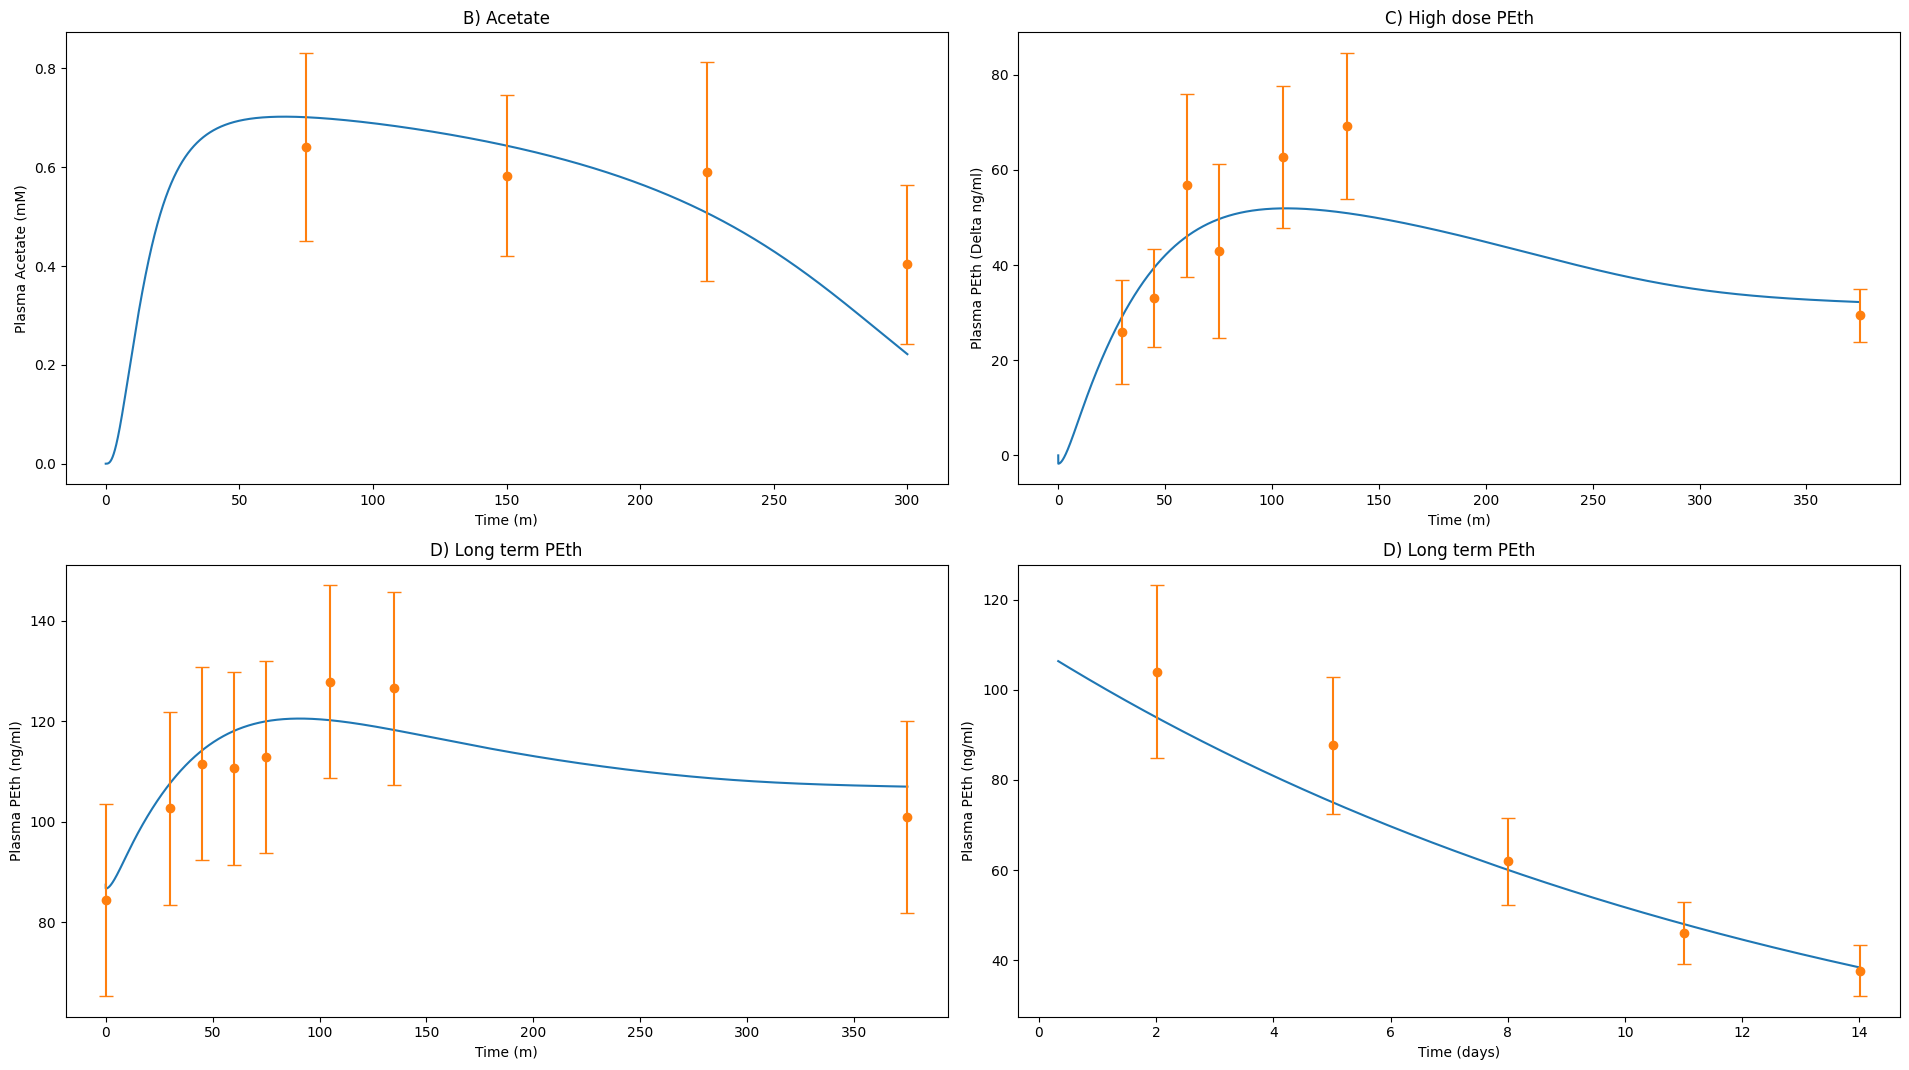

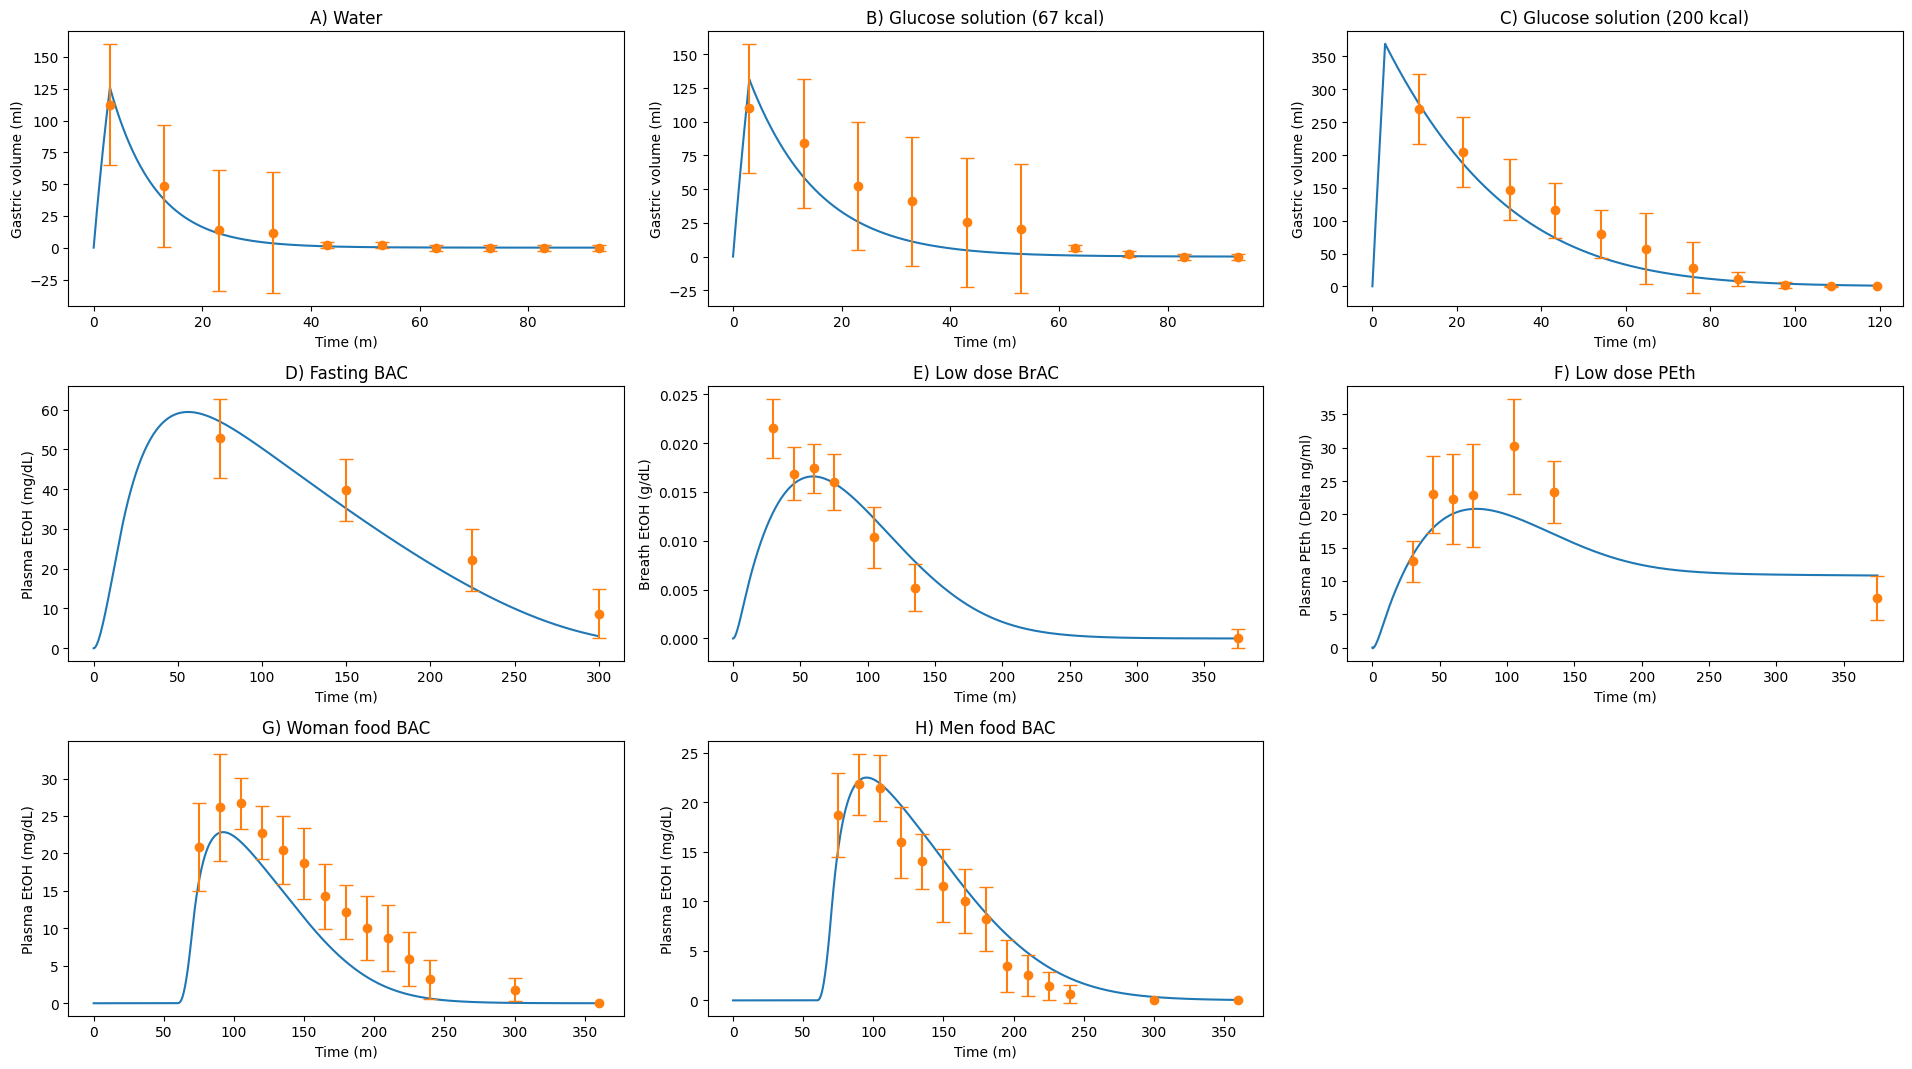

In [7]:
# %% Simulate and plot agreement to data
def plot_agreement(p, sims, D):
    ic_PEth_L = p[-2]
    ic_PEth_H = p[-1]
    p = p[0:-2]
    p_names = model.parameternames
    ic_org = model.statevalues.copy()
    PEth_bound_scale = p[p_names.index("kPEth_bind")] / p[p_names.index("kPEth_release")] + 1


    plot_info = {k:{} for k in all_data.keys()}

    for key, observable, fig, position, title, ylabel in zip(["Okabe_Water", "Okabe_Orange", "Okabe_Orange_Syrup", "Okabe_Milk_Water", "Okabe_Milk", "Okabe_Whiskey", "Okabe_UG200", "Okabe_UG600", "Mitchell_Beer", "Mitchell_Wine", "Mitchell_Spirit", "Jones_Fasting", "Kechagias_Fasting", "Javors_High", "Jones_Food", "Kechagias_Breakfast", "Sarkola", "Javors_High", "Javors_Combined", "Okabe_Water2", "Okabe_Glucose","Okabe_UG400", "Sarkola", "Javors_Low", "Javors_Low", "Frezza_Woman", "Frezza_Men"], 
                                                ["Gastric volume", "Gastric volume", "Gastric volume", "Gastric volume", "Gastric volume", "Gastric volume","Gastric volume", "Gastric volume", "EtOH", "EtOH", "EtOH", "EtOH", "EtOH", "BrAC", "EtOH", "EtOH", "Acetate", "PEth", "PEth", "Gastric volume", "Gastric volume", "Gastric volume", "EtOH", "BrAC", "PEth", "EtOH", "EtOH"],
                                                [1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4],
                                                [1, 2, 3, 5, 6, 7, 8, 9, 1, 2, 3, 4, 5, 6, 7, 8, 1, 2, 3, 1, 2, 3, 4, 5, 6, 7, 8],
                                                ["A) Water (0 kcal)", "B) Orange (220 kcal)", "C) Orange + syrup (329 kcal)", "E) Milk (329 kcal)", "D) Diluted milk (220 kcal)", "F) Diluted whiskey", "G) Glucose solution (200 kcal)", "H) Glucose solution (200 kcal)", "A) Beer BAC", "B) Wine BAC", "C) Spirit BAC", "D) Fasting BAC", "E) Fasting BAC", "F) High dose BrAC", "G) Food BAC", "H) Food BAC", "B) Acetate", "C) High dose PEth","D) Long term PEth", "A) Water", "B) Glucose solution (67 kcal)","C) Glucose solution (200 kcal)", "D) Fasting BAC", "E) Low dose BrAC", "F) Low dose PEth", "G) Woman food BAC", "H) Men food BAC"], ["Gastric volume", "Gastric volume", "Gastric volume", "Gastric volume", "Gastric volume", "Gastric volume","Gastric volume", "Gastric volume", "Plasma EtOH", "Plasma EtOH", "Plasma EtOH", "Plasma EtOH", "Plasma EtOH", "Breath EtOH", "Plasma EtOH", "Plasma EtOH", "Plasma Acetate", "Plasma PEth", "Plasma PEth", "Gastric volume", "Gastric volume", "Gastric volume", "Plasma EtOH", "Breath EtOH", "Plasma PEth", "Plasma EtOH", "Plasma EtOH"]):
        plot_info[key][observable] = {"fig": fig, "pos": position, "title":title, "ylabel":ylabel}

    figs = [plt.figure(figsize=(19.2, 10.8)), plt.figure(figsize=(19.2, 10.8)), plt.figure(figsize=(19.2, 10.8)), plt.figure(figsize=(19.2, 10.8))]

    for k_exp, d in D.items():
        # Special cases for Javors PEth
        if k_exp == "Javors_Combined":
            continue
        elif k_exp == "Javors_Low":
            ic[model.statenames.index("PEth")] = ic_PEth_L
            ic[model.statenames.index("PEth_Bound")] = ic_PEth_L*PEth_bound_scale
        elif  k_exp == "Javors_High":
            ic[model.statenames.index("PEth")] = ic_PEth_H
            ic[model.statenames.index("PEth_Bound")] = ic_PEth_H*PEth_bound_scale
        else:
            ic = ic_org

        times = sorted([t for k, var in d.items()  if k not in ["input", "meta", "extra"] for t in var["Time"]])
        t_highres = np.arange(0, times[-1], 0.01)

        sim = sims[k_exp]
        sim.ResetStatesDerivatives()
        sim.Simulate(timevector = t_highres, parametervalues = p,  statevalues = ic)

        for k_obs, obs in d.items():
            if k_obs not in ["input", "meta", "extra"]:

                fignum = plot_info[k_exp][k_obs]["fig"]
                if fignum == 3: 
                    m,n = 2,2
                else:
                    m,n = 3,3
                fig = figs[fignum-1]
                ax = fig.add_subplot(m,n,plot_info[k_exp][k_obs]["pos"])

                idx = sim.featurenames.index(k_obs)
                y_sim = sim.featuredata[:,idx]
                if "Javors" in k_exp:
                    y_sim-=y_sim[0]
                ax.plot(sim.timevector, y_sim)
                ax.errorbar(obs['Time'], obs['Mean'], obs['SEM'], marker='o', capsize=5, linestyle='')
                ax.set_xlabel(f"Time ({sim.timeunit})")
                ax.set_title(plot_info[k_exp][k_obs]["title"])
                if "Unit" in obs.keys():
                    ax.set_ylabel(f"{plot_info[k_exp][k_obs]['ylabel']} ({obs['Unit']})")
                else:
                    ax.set_ylabel(f"{plot_info[k_exp][k_obs]['ylabel']}")

    if "Javors_Combined" in D.keys():

        obs = D["Javors_Combined"]["PEth"]
        k_obs = "PEth"
        t_short_term = max(D["Javors_Low"]["PEth"]["Time"])
        t1 = np.arange(0, t_short_term, 0.01)
        t2 = np.arange(t_short_term, max(obs["Time"]), 1)

        ic_L = ic_org.copy()
        ic_H =ic_org.copy()
        ic_L[model.statenames.index("PEth")] = ic_PEth_L
        ic_L[model.statenames.index("PEth_Bound")] = ic_PEth_L*PEth_bound_scale
        ic_H[model.statenames.index("PEth")] = ic_PEth_H
        ic_H[model.statenames.index("PEth_Bound")] = ic_PEth_H*PEth_bound_scale

        sim_low = sims["Javors_Low"]
        sim_low.Simulate(timevector = t1, parametervalues = p,  statevalues = ic_L)
        sim_low_short = copy.copy(sim_low)
        sim_low.Simulate(timevector = t2, parametervalues = p)

        sim_high = sims["Javors_High"]
        sim_high.Simulate(timevector = t1, parametervalues = p,  statevalues = ic_H)
        sim_high_short = copy.copy(sim_high)
        sim_high.Simulate(timevector = t2, parametervalues = p)
        idx_PEth = sim_low.featurenames.index("PEth")

        PEth_L_short = sim_low_short.featuredata[:, idx_PEth]
        PEth_H_short = sim_high_short.featuredata[:, idx_PEth]
        PEth_L_long = sim_low.featuredata[:, idx_PEth]
        PEth_H_long = sim_high.featuredata[:, idx_PEth]

        obs = D["Javors_Combined"]["PEth"]
        y_sim_short = combine_PEth(PEth_L_short, PEth_H_short)
        y_sim_long = combine_PEth(PEth_L_long, PEth_H_long)

        idx_short_t = obs["Time"].index(t_short_term)+1
        
        fignum = plot_info["Javors_Combined"]["PEth"]["fig"]
        fig = figs[fignum-1]
        ax = fig.add_subplot(2,2,plot_info["Javors_Combined"]["PEth"]["pos"])
        ax.plot(sim_low_short.timevector, y_sim_short)
        ax.errorbar(obs['Time'][:idx_short_t], obs['Mean'][:idx_short_t], obs['SEM'][idx_short_t], marker='o', capsize=5, linestyle='')
        ax.set_xlabel(f"Time ({sim_low.timeunit})")
        ax.set_title(plot_info["Javors_Combined"]["PEth"]["title"])
        ax.set_ylabel(f"{plot_info['Javors_Combined']['PEth']['ylabel']} ({obs['Unit']})")


        ax = fig.add_subplot(2,2,plot_info["Javors_Combined"]["PEth"]["pos"]+1)
        ax.plot(sim_low.timevector[100:]/(60*24), y_sim_long[100:])
        ax.errorbar(np.array(obs['Time'][idx_short_t:])/(60*24), obs['Mean'][idx_short_t:], obs['SEM'][idx_short_t:], marker='o', capsize=5, linestyle='')
        ax.set_xlabel(f"Time (days)")
        ax.set_title(plot_info["Javors_Combined"]["PEth"]["title"])
        ax.set_ylabel(f"{plot_info['Javors_Combined']['PEth']['ylabel']} ({obs['Unit']})")

    fignames = ["estimation Gastric", "estimation EtOH", "estimation EtOH derivates", "validation"]
    for i in range(4):
        fig = figs[i]
        fig.tight_layout()
        fig.savefig(f"./figures/{fignames[i]}.png")

plot_agreement(params, sims, all_data)